In [3]:
# process_data.py
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, coalesce, lit, when,
    collect_list, concat_ws, count,
    lower, first
)


# train_recommender.py
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch_geometric.transforms import ToUndirected, RandomLinkSplit

# New imports for image processing
from sentence_transformers import SentenceTransformer
from PIL import Image
import requests
import os

def main():
    """
    Main function to process Amazon Fashion data and prepare it for a graph model.
    """
    # Configure and create the Spark Session
    conf = pyspark.SparkConf().setAll([
        ('spark.driver.memory', '8g'),
        ('spark.executor.memory', '8g')
    ])
    spark = SparkSession.builder \
        .appName("AmazonFashionGraphRecSys") \
        .config(conf=conf) \
        .getOrCreate()
    spark.conf.set("spark.sql.legacy.allowColonInFieldNames", "true")

    # Load the raw dataset
    df_raw = spark.read.json("AMAZON_FASHION.json")

    # --- NEW: Extract and save item image URLs ---
    print("Extracting and saving item image URLs...")
    df_item_images = df_raw.select(
        col("asin").alias("item_id"),
        col("image")
    ).distinct()
    df_item_images.write.mode("overwrite").parquet("item_images.parquet")
    print("Successfully saved 'item_images.parquet'")
    # --- End of New Section ---


    # Select necessary columns and perform K-Core filtering
    df_filtered = df_raw.select(
        col("reviewerID").alias("user_id"),
        col("asin").alias("item_id"),
        col("overall").alias("rating"),
        col("unixReviewTime").alias("timestamp"),
        "style",
        "summary",
        "reviewText"
    ).dropna(subset=["user_id", "item_id"])

    min_reviews_per_item = 5
    min_reviews_per_user = 2
    item_counts = df_filtered.groupBy("item_id").count().where(col('count') >= min_reviews_per_item)
    df_filtered = df_filtered.join(item_counts.select("item_id"), on="item_id", how="inner")
    user_counts = df_filtered.groupBy("user_id").count().where(col('count') >= min_reviews_per_user)
    df_filtered = df_filtered.join(user_counts.select("user_id"), on="user_id", how="inner")

    # Sample from the filtered dataset and cache it
    df_subset = df_filtered.sample(withReplacement=False, fraction=0.6, seed=42)
    df_subset.cache()

    # --- Item Node Feature Engineering (No UDFs) ---
    df_item_text = df_subset.groupBy("item_id").agg(
        concat_ws(" ", collect_list(coalesce(col("summary"), lit(""))), collect_list(coalesce(col("reviewText"), lit("")))).alias("item_description")
    )

    df_item_style = df_subset.groupBy("item_id").agg(
        first("style").alias("style")
    ).select(
        "item_id",
        coalesce(
            col("style.Style:"), col("style.Style Name:"), col("style.Scent Name:"),
            col("style.Size Name:"), col("style.Material:")
        ).alias("product_type_from_style"),
        col("style.Color:").alias("color")
    )

    df_item_text = df_item_text.withColumn("desc_lower", lower(col("item_description")))
    product_type_expr = (
        when(col("desc_lower").rlike(r'\bdress(es)?\b'), "Dress")
        .when(col("desc_lower").rlike(r'\b(shoe|boot|sneaker|sandal|heel)s?\b'), "Shoes")
        .when(col("desc_lower").rlike(r'\b(shirt|top|blouse|t-shirt)s?\b'), "Top")
        .when(col("desc_lower").rlike(r'\b(pant|jean|short|bottom|skirt)s?\b'), "Bottoms")
        .when(col("desc_lower").rlike(r'\b(jacket|coat|outerwear)\b'), "Outerwear")
        .when(col("desc_lower").rlike(r'\b(bag|purse|wallet|accessory)\b'), "Accessory")
        .when(col("desc_lower").rlike(r'\b(jewelry|necklace|ring|earring)s?\b'), "Jewelry")
        .otherwise("Unknown_Fashion_Item")
    )
    df_item_text = df_item_text.withColumn("product_type_from_text", product_type_expr)

    df_items = df_item_text.join(df_item_style, "item_id", "left").withColumn(
        "product_type",
        coalesce(col("product_type_from_style"), col("product_type_from_text"))
    ).select(
        "item_id", "product_type", "color", "item_description"
    )

    # --- Create Graph Edges ---
    df_edges = df_subset.select(
        col("user_id"), col("item_id"),
        col("rating").cast("float"),
        col("timestamp").cast("long")
    ).distinct()

    # Save the main feature and edge files
    df_items.write.mode("overwrite").parquet("items_features.parquet")
    df_edges.write.mode("overwrite").parquet("user_item_edges.parquet")

    print("Successfully processed and saved 'items_features.parquet' and 'user_item_edges.parquet'")

    spark.stop()

if __name__ == '__main__':
    main()

Extracting and saving item image URLs...
Successfully saved 'item_images.parquet'


Successfully processed and saved 'items_features.parquet' and 'user_item_edges.parquet'


In [4]:
# Pandas can read the Parquet file directory seamlessly
items_df = pd.read_parquet("items_features.parquet")
edges_df = pd.read_parquet("user_item_edges.parquet")

# Your DataFrame will be perfectly structured with no parsing errors.
print(items_df.head())

      item_id product_type   color  \
0  B000085HZL    Accessory    None   
1  B00008JOQI          Top    None   
2  B00061RFTW      Jewelry    None   
3  B00062NHH0          Top   White   
4  B00063VWTY          Top    None   

                                    item_description  
0  Great Quality!!!!!! If you want a wallet to ho...  
1  If only it had two cuff buttons! Five Stars Go...  
2  Just right. I love this ring!! I have small fi...  
3  I love these shirts. no V-Neck T-Shirt Calvin ...  
4  Stylin'! Outstanding and well formed great rep...  


In [34]:
def main():
    # --- 1. Load the Data ---
    print("Loading data...")
    items_df = pd.read_parquet("items_features.parquet")
    edges_df = pd.read_parquet("user_item_edges.parquet")
    try:
        images_df = pd.read_parquet("item_images.parquet")
        images_df.rename(columns={'asin': 'item_id'}, inplace=True)
        
        # --- THIS IS THE CORRECTED LINE ---
        # Explicitly check the size of the array to avoid ambiguity
        images_df['image_url'] = images_df['image'].apply(
            lambda x: x[0] if x is not None and x.size > 0 else None
        )
        # --- END OF CORRECTION ---

        items_df = items_df.merge(images_df[['item_id', 'image_url']], on='item_id', how='left')
    except Exception as e:
        print(f"Could not load image URLs, skipping image features. Error: {e}")
        items_df['image_url'] = None


    # --- 2. Text and Categorical Feature Engineering & Encoding ---
    print("Encoding features...")
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    edges_df['user_idx'] = user_encoder.fit_transform(edges_df['user_id'])
    edges_df['item_idx'] = item_encoder.fit_transform(edges_df['item_id'])
    
    items_df['item_idx'] = item_encoder.transform(items_df['item_id'])
    items_df = items_df.sort_values('item_idx').set_index('item_idx')

    items_df['item_description'] = items_df['item_description'].fillna('')
    vectorizer = TfidfVectorizer(max_features=128)
    description_encoded = vectorizer.fit_transform(items_df['item_description']).toarray()
    text_features_tensor = torch.tensor(description_encoded, dtype=torch.float)

    # --- 2a. Image Feature Engineering ---
    print("Generating image embeddings (this may take a while)...")
    img_model = SentenceTransformer('clip-ViT-B-32')
    
    if not os.path.exists('images'):
        os.makedirs('images')

    image_embeddings = []
    for idx, row in items_df.iterrows():
        img_path = f"images/{row['item_id']}.jpg"
        if row['image_url'] and not os.path.exists(img_path):
            try:
                response = requests.get(row['image_url'], stream=True, timeout=5)
                if response.status_code == 200:
                    with open(img_path, 'wb') as f:
                        f.write(response.content)
            except requests.exceptions.RequestException:
                pass 

        if os.path.exists(img_path):
            try:
                img_emb = img_model.encode(Image.open(img_path))
                image_embeddings.append(img_emb)
            except Exception:
                image_embeddings.append(np.zeros(512))
        else:
            image_embeddings.append(np.zeros(512))

    image_features_tensor = torch.tensor(np.array(image_embeddings), dtype=torch.float)

    # --- 2b. Combine All Features ---
    print("Combining all features into a single tensor...")
    item_features_tensor = torch.cat([text_features_tensor, image_features_tensor], dim=1)

    # --- 3. Construct Heterogeneous Graph ---
    print("Constructing graph...")
    data = HeteroData()
    data['user'].num_nodes = len(user_encoder.classes_)
    data['item'].x = item_features_tensor
    
    edge_index_user_item = torch.tensor(edges_df[['user_idx', 'item_idx']].values.T, dtype=torch.long)
    edge_ratings = torch.tensor(edges_df['rating'].values, dtype=torch.float)
    data['user', 'rates', 'item'].edge_index = edge_index_user_item
    data['user', 'rates', 'item'].edge_attr = edge_ratings

    data = ToUndirected()(data)

    # --- 4. Define the GraphSAGE Model ---
    class GNNEncoder(torch.nn.Module):
        def __init__(self, hidden_channels, out_channels):
            super().__init__()
            self.conv1 = SAGEConv((-1, -1), hidden_channels)
            self.conv2 = SAGEConv((-1, -1), out_channels)
        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index)
            return x

    class EdgeDecoder(torch.nn.Module):
        def __init__(self, hidden_channels):
            super().__init__()
            self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
            self.lin2 = torch.nn.Linear(hidden_channels, 1)
        def forward(self, z_dict, edge_label_index):
            row, col = edge_label_index
            z = torch.cat([z_dict['user'][row], z_dict['item'][col]], dim=-1)
            z = self.lin1(z).relu()
            z = self.lin2(z)
            return z.view(-1)

    class Model(torch.nn.Module):
        def __init__(self, hidden_channels, num_users):
            super().__init__()
            self.user_emb = torch.nn.Embedding(num_users, hidden_channels)
            self.encoder = GNNEncoder(hidden_channels, hidden_channels)
            self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
            self.decoder = EdgeDecoder(hidden_channels)
        def forward(self, x_dict, edge_index_dict, edge_label_index):
            user_x = self.user_emb(x_dict['user'])
            x_dict_encoded = {"user": user_x, "item": x_dict["item"]}
            z_dict = self.encoder(x_dict_encoded, edge_index_dict)
            return self.decoder(z_dict, edge_label_index)

    model = Model(hidden_channels=64, num_users=data['user'].num_nodes)
    
    # --- 5. Train the Model ---
    print("Training the model...")
    data['user'].x = torch.arange(data['user'].num_nodes)
    transform = RandomLinkSplit(
        is_undirected=True, num_val=0.1, num_test=0.1,
        neg_sampling_ratio=0.0, add_negative_train_samples=False,
        edge_types=[('user', 'rates', 'item')],
        rev_edge_types=[('item', 'rev_rates', 'user')]
    )
    train_data, val_data, test_data = transform(data)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    for epoch in range(1, 51):
        model.train()
        optimizer.zero_grad()
        pred = model(
            train_data.x_dict,
            train_data.edge_index_dict,
            train_data['user', 'item'].edge_label_index
        )
        target = train_data['user', 'item'].edge_attr
        loss = F.mse_loss(pred, target)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Loss (MSE): {loss:.4f}")
    
    print("Training complete.")

if __name__ == '__main__':
    main()

Loading data...
Encoding features...
Generating image embeddings (this may take a while)...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (1, 1, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got 

Combining all features into a single tensor...
Constructing graph...
Training the model...
Epoch: 010, Loss (MSE): 12.5330
Epoch: 020, Loss (MSE): 2.2049
Epoch: 030, Loss (MSE): 1.5568
Epoch: 040, Loss (MSE): 1.3389
Epoch: 050, Loss (MSE): 1.0714
Training complete.


In [5]:
# train_recommender_gat.py
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import GATConv, to_hetero
import torch.nn.functional as F
from torch_geometric.transforms import ToUndirected, RandomLinkSplit

def main():
    # --- 1. Load the Data ---
    print("Loading data...")
    items_df = pd.read_parquet("items_features.parquet")
    edges_df = pd.read_parquet("user_item_edges.parquet")

    # --- 2. Feature Engineering & Encoding ---
    print("Encoding features...")
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    edges_df['user_idx'] = user_encoder.fit_transform(edges_df['user_id'])
    edges_df['item_idx'] = item_encoder.fit_transform(edges_df['item_id'])
    
    items_df['item_idx'] = item_encoder.transform(items_df['item_id'])
    items_df = items_df.sort_values('item_idx').set_index('item_idx')

    # --- 2a. Re-combine Text and Categorical Features ---
    print("Creating combined item features...")
    # Text features
    items_df['item_description'] = items_df['item_description'].fillna('')
    vectorizer = TfidfVectorizer(max_features=128)
    description_encoded = vectorizer.fit_transform(items_df['item_description']).toarray()

    # Categorical features
    product_type_encoded = pd.get_dummies(items_df['product_type'], prefix='type').to_numpy()
    color_encoded = pd.get_dummies(items_df['color'], prefix='color').to_numpy()

    # Combine all features into a single matrix
    combined_features = np.concatenate([description_encoded, product_type_encoded, color_encoded], axis=1)
    item_features_tensor = torch.tensor(combined_features, dtype=torch.float)

    # --- 2b. Normalize Timestamps ---
    # Normalizing time features is crucial for stable training
    scaler = StandardScaler()
    edges_df['timestamp_scaled'] = scaler.fit_transform(edges_df[['timestamp']])


    # --- 3. Construct Heterogeneous Graph with Time ---
    print("Constructing graph with temporal edges...")
    data = HeteroData()

    data['user'].num_nodes = len(user_encoder.classes_)
    data['item'].x = item_features_tensor

    # Add edges with ratings (edge_attr) and time (edge_time)
    edge_index = torch.tensor(edges_df[['user_idx', 'item_idx']].values.T, dtype=torch.long)
    edge_attr = torch.tensor(edges_df['rating'].values, dtype=torch.float)
    edge_time = torch.tensor(edges_df['timestamp_scaled'].values, dtype=torch.float).view(-1, 1) # Reshape for concatenation
    
    data['user', 'rates', 'item'].edge_index = edge_index
    data['user', 'rates', 'item'].edge_attr = edge_attr
    data['user', 'rates', 'item'].edge_time = edge_time # New temporal attribute

    data = ToUndirected()(data)

    # --- 4. Define the Graph Attention (GAT) Model ---
    class GATEncoder(torch.nn.Module):
        def __init__(self, hidden_channels, out_channels):
            super().__init__()
            self.conv1 = GATConv((-1, -1), hidden_channels, heads=4, add_self_loops=False)
            self.conv2 = GATConv((-1, -1), out_channels, heads=1, add_self_loops=False)
        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index)
            return x

    # The decoder is now time-aware and uses a clearer variable name
    class EdgeDecoder(torch.nn.Module):
        def __init__(self, hidden_channels):
            super().__init__()
            self.lin1 = torch.nn.Linear(2 * hidden_channels + 1, hidden_channels)
            self.lin2 = torch.nn.Linear(hidden_channels, 1)

        # --- THIS IS CORRECTED ---
        # Renamed 'edge_label_index' to 'supervision_edge_index' for clarity
        def forward(self, z_dict, supervision_edge_index, edge_time):
            row, col = supervision_edge_index
        # --- END OF CORRECTION ---
            z = torch.cat([z_dict['user'][row], z_dict['item'][col], edge_time], dim=-1)
            z = self.lin1(z).relu()
            z = self.lin2(z)
            return z.view(-1)

    class Model(torch.nn.Module):
        def __init__(self, hidden_channels, num_users):
            super().__init__()
            self.user_emb = torch.nn.Embedding(num_users, hidden_channels)
            self.encoder = GATEncoder(hidden_channels, hidden_channels)
            self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
            self.decoder = EdgeDecoder(hidden_channels)

        # --- THIS IS CORRECTED ---
        # Renamed 'edge_label_index' to 'supervision_edge_index' for clarity
        def forward(self, x_dict, edge_index_dict, supervision_edge_index, edge_time):
        # --- END OF CORRECTION ---
            user_x = self.user_emb(x_dict['user'])
            x_dict_encoded = {"user": user_x, "item": x_dict["item"]}
            z_dict = self.encoder(x_dict_encoded, edge_index_dict)
            return self.decoder(z_dict, supervision_edge_index, edge_time)

    model = Model(hidden_channels=64, num_users=data['user'].num_nodes)

    # --- 5. Train the Model ---
    print("Training the GAT model...")
    data['user'].x = torch.arange(data['user'].num_nodes)

    transform = RandomLinkSplit(
        is_undirected=True, num_val=0.1, num_test=0.1,
        neg_sampling_ratio=0.0, add_negative_train_samples=False,
        edge_types=[('user', 'rates', 'item')],
        rev_edge_types=[('item', 'rev_rates', 'user')],
        key='edge_time'
    )
    train_data, val_data, test_data = transform(data)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    edge_type = ('user', 'rates', 'item')

    for epoch in range(1, 51):
        model.train()
        optimizer.zero_grad()

        # --- THIS BLOCK IS CORRECTED ---
        # We pass the training data's own 'edge_index' for supervision
        pred = model(
            train_data.x_dict,
            train_data.edge_index_dict,
            train_data[edge_type].edge_index, # Use edge_index, NOT edge_label_index
            train_data[edge_type].edge_time
        )
        target = train_data[edge_type].edge_attr
        # --- END OF CORRECTION ---

        loss = F.mse_loss(pred, target)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Loss (MSE): {loss:.4f}")

    print("Training complete.")

if __name__ == '__main__':
    main()

Loading data...
Encoding features...
Creating combined item features...
Constructing graph with temporal edges...
Training the GAT model...
Epoch: 010, Loss (MSE): 10.9856
Epoch: 020, Loss (MSE): 3.1985
Epoch: 030, Loss (MSE): 1.7753
Epoch: 040, Loss (MSE): 1.4295
Epoch: 050, Loss (MSE): 1.3444
Training complete.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def analyze_user_communities(model, edge_index_full, user_encoder):
    """
    Analyzes and visualizes user communities from trained LightGCN embeddings.
    Args:
            model: The trained LightGCN model object.
            edge_index_full: The full edge index used for training.
            user_encoder: The fitted LabelEncoder for users.
    """
    print("\n--- Starting User Community Analysis ---")

    # Set the model to evaluation mode
    model.eval()

    # 1. Extract the final user embeddings from the trained encoder
    with torch.no_grad():
        final_user_emb, _ = model.encoder(edge_index_full)
    user_embeddings_np = final_user_emb.cpu().numpy()
    print(f"Extracted {user_embeddings_np.shape[0]} user embeddings of dimension {user_embeddings_np.shape[1]}.")

    # 2. Use t-SNE to reduce the embeddings from 64D to 2D for plotting
    # Perplexity is a key parameter; a good starting point is around 30-50.
    print("Performing t-SNE dimensionality reduction (this can take a moment)...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=300, init='pca')
    user_embeddings_2d = tsne.fit_transform(user_embeddings_np)
    print("t-SNE complete.")

    # 3. Create a scatter plot to visualize the user communities
    plt.figure(figsize=(14, 12))
    sns.scatterplot(
        x=user_embeddings_2d[:, 0],
        y=user_embeddings_2d[:, 1],
        s=30,          # Set marker size
        alpha=0.6,     # Set marker transparency
        edgecolor='none' # Remove marker borders for a cleaner look
    )
    plt.title('User Communities Visualized with t-SNE', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

Loading data...
Encoding features...
Constructing graph with temporal edges...
Training the LightGCN model...
Epoch: 010, Loss (MSE): 2.5609
Epoch: 020, Loss (MSE): 1.4850
Epoch: 030, Loss (MSE): 0.8573
Epoch: 040, Loss (MSE): 0.6043
Epoch: 050, Loss (MSE): 0.4674
Training complete.

--- Starting User Community Analysis ---
Extracted 54117 user embeddings of dimension 64.
Performing t-SNE dimensionality reduction (this can take a moment)...
t-SNE complete.


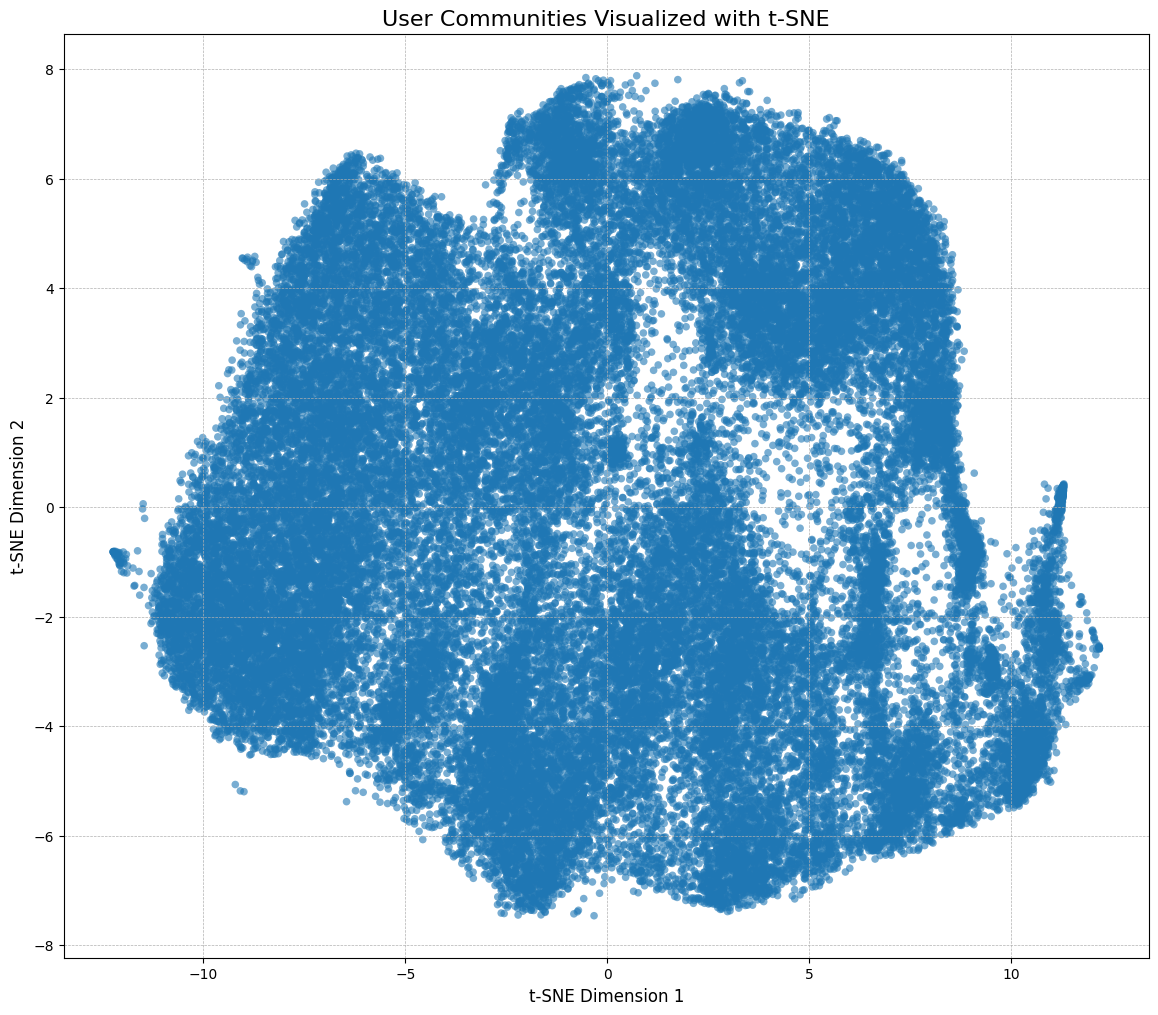

In [13]:
# train_recommender_lightgcn.py
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.transforms import ToUndirected, RandomLinkSplit

def main():
    # --- Sections 1, 2, and 3 remain the same ---
    # --- 1. Load the Data ---
    print("Loading data...")
    items_df = pd.read_parquet("items_features.parquet")
    edges_df = pd.read_parquet("user_item_edges.parquet")

    # --- 2. Feature Engineering & Encoding ---
    print("Encoding features...")
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    edges_df['user_idx'] = user_encoder.fit_transform(edges_df['user_id'])
    edges_df['item_idx'] = item_encoder.fit_transform(edges_df['item_id'])
    
    items_df['item_idx'] = item_encoder.transform(items_df['item_id'])
    items_df = items_df.sort_values('item_idx').set_index('item_idx')

    # Create combined item features
    items_df['item_description'] = items_df['item_description'].fillna('')
    vectorizer = TfidfVectorizer(max_features=128)
    description_encoded = vectorizer.fit_transform(items_df['item_description']).toarray()
    product_type_encoded = pd.get_dummies(items_df['product_type'], prefix='type').to_numpy()
    color_encoded = pd.get_dummies(items_df['color'], prefix='color').to_numpy()
    combined_features = np.concatenate([description_encoded, product_type_encoded, color_encoded], axis=1)
    
    # Normalize Timestamps
    scaler = StandardScaler()
    edges_df['timestamp_scaled'] = scaler.fit_transform(edges_df[['timestamp']])

    # --- 3. Construct Heterogeneous Graph with Time ---
    print("Constructing graph with temporal edges...")
    data = HeteroData()
    data['user'].num_nodes = len(user_encoder.classes_)
    data['item'].x = torch.tensor(combined_features, dtype=torch.float)
    
    edge_index = torch.tensor(edges_df[['user_idx', 'item_idx']].values.T, dtype=torch.long)
    edge_attr = torch.tensor(edges_df['rating'].values, dtype=torch.float)
    edge_time = torch.tensor(edges_df['timestamp_scaled'].values, dtype=torch.float).view(-1, 1)
    
    data['user', 'rates', 'item'].edge_index = edge_index
    data['user', 'rates', 'item'].edge_attr = edge_attr
    data['user', 'rates', 'item'].edge_time = edge_time

    data = ToUndirected()(data)

    # --- 4. Define the LightGCN Model ---
    class LightGCN(torch.nn.Module):
        def __init__(self, num_users, num_items, hidden_channels, num_layers):
            super().__init__()
            self.num_users = num_users
            self.num_items = num_items
            self.num_layers = num_layers
            self.hidden_channels = hidden_channels

            # Learnable embeddings for users and items
            self.user_emb = torch.nn.Embedding(num_users, hidden_channels)
            self.item_emb = torch.nn.Embedding(num_items, hidden_channels)
            
            # Define the GCNConv layer here, in the constructor
            self.convs = torch.nn.ModuleList(
                [GCNConv(hidden_channels, hidden_channels, normalize=True) for _ in range(num_layers)]
            )

            torch.nn.init.normal_(self.user_emb.weight, std=0.1)
            torch.nn.init.normal_(self.item_emb.weight, std=0.1)

        def forward(self, edge_index):
            user_emb = self.user_emb.weight
            item_emb = self.item_emb.weight
            
            out_user_emb = user_emb
            out_item_emb = item_emb

            for i in range(self.num_layers):
                # We need to construct the full graph for propagation
                all_emb = torch.cat([user_emb, item_emb], dim=0)
                
                # **FIX:** Call the predefined layer
                all_emb = self.convs[i](all_emb, edge_index)
                
                user_emb, item_emb = torch.split(all_emb, [self.num_users, self.num_items])
                
                # Sum embeddings from each layer
                out_user_emb = out_user_emb + user_emb
                out_item_emb = out_item_emb + item_emb

            # The final embeddings are the mean of the embeddings from all layers
            return out_user_emb / (self.num_layers + 1), out_item_emb / (self.num_layers + 1)

    # The decoder remains the same
    class EdgeDecoder(torch.nn.Module):
        def __init__(self, hidden_channels):
            super().__init__()
            self.lin1 = torch.nn.Linear(2 * hidden_channels + 1, hidden_channels)
            self.lin2 = torch.nn.Linear(hidden_channels, 1)
        def forward(self, user_emb, item_emb, edge_time):
            z = torch.cat([user_emb, item_emb, edge_time], dim=-1)
            z = self.lin1(z).relu()
            z = self.lin2(z)
            return z.view(-1)

    class Model(torch.nn.Module):
        def __init__(self, num_users, num_items, hidden_channels, num_layers=3):
            super().__init__()
            self.encoder = LightGCN(num_users, num_items, hidden_channels, num_layers)
            self.decoder = EdgeDecoder(hidden_channels)

        def forward(self, edge_index, supervision_edge_index, edge_time):
            final_user_emb, final_item_emb = self.encoder(edge_index)
            user_emb_supervision = final_user_emb[supervision_edge_index[0]]
            item_emb_supervision = final_item_emb[supervision_edge_index[1]]
            return self.decoder(user_emb_supervision, item_emb_supervision, edge_time)

    num_users = data['user'].num_nodes
    num_items = data['item'].num_nodes
    model = Model(num_users, num_items, hidden_channels=64, num_layers=3)
    
    # --- 5. Train the Model ---
    print("Training the LightGCN model...")
    transform = RandomLinkSplit(
        is_undirected=True, num_val=0.1, num_test=0.1,
        neg_sampling_ratio=0.0, add_negative_train_samples=False,
        edge_types=[('user', 'rates', 'item')],
        rev_edge_types=[('item', 'rev_rates', 'user')],
        key='edge_time'
    )
    train_data, val_data, test_data = transform(data)
    
    # Create the unified edge index for LightGCN propagation
    # We need to offset the item indices to create a single node index space
    user_item_edge_index = data['user', 'rates', 'item'].edge_index
    item_user_edge_index = data['item', 'rev_rates', 'user'].edge_index
    item_user_edge_index[0] += num_users # Offset item indices
    item_user_edge_index[1] -= num_users # This is wrong, should be item_user_edge_index[1] += 0, as user indices are already 0-indexed
    # Let's rebuild it properly
    u_idx, i_idx = data['user', 'rates', 'item'].edge_index
    i_idx_offset = i_idx + num_users
    # Edges from user to item and from item to user
    edge_index_full = torch.cat([
        torch.stack([u_idx, i_idx_offset]),
        torch.stack([i_idx_offset, u_idx])
    ], dim=1)


    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    edge_type = ('user', 'rates', 'item')

    for epoch in range(1, 51):
        model.train()
        optimizer.zero_grad()
        
        pred = model(
            edge_index_full, # Use the full, unified edge index for propagation
            train_data[edge_type].edge_index,
            train_data[edge_type].edge_time
        )
        target = train_data[edge_type].edge_attr
        
        loss = F.mse_loss(pred, target)
        # Add a small regularization loss, common for LightGCN
        l2_loss = 1e-4 * (
            model.encoder.user_emb.weight.norm(2) + model.encoder.item_emb.weight.norm(2)
        )
        loss += l2_loss

        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Loss (MSE): {loss:.4f}")
    
    print("Training complete.")
    
    analyze_user_communities(model, edge_index_full, user_encoder)

if __name__ == '__main__':
    main()